In [1]:
import pandas as pd
import numpy as np
import re
import math
import random
import os

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

%matplotlib inline
#%matplotlib notebook

Using TensorFlow backend.


In [2]:
s = np.random.uniform(0,6,10)
l = [0,1,2,3,4,5,6]
print(s)
np.var(l)

[5.15038723 5.31425326 5.49364319 0.9595091  4.01902735 3.34958214
 1.74487862 5.13221971 4.20524123 5.58910956]


4.0

In [3]:
import scipy

In [4]:
for x in range(-3,4):
    print((3*(x**2)-(8*x+6))*(x**2)-12, (3*(x**4))-(8*(x**3))+(6*(x**2))-12, x)

393 501 -3
76 124 -2
-7 5 -1
-12 -12 0
-23 -11 1
-52 -4 2
-39 69 3


In [5]:
import warnings
warnings.filterwarnings('ignore') #чтобы красные уведомления внизу ячеек не отсвечивали

In [6]:
np.random.seed(42) # если оставить, то при каждом перезапуске ноутбука результаты будут одинаковыми, если убрать - то разными

## Считываем и первично обрабатываем данные

In [7]:
label = 'x4'
title = 'Численность официально зарегистрированных\n в службе занятости безработных, получающих пособие, тыс'

In [8]:
df = pd.read_csv('forecasting.csv', sep=';')
df = df[['quarter_date', label]]

In [9]:
df[label] = df[label].apply(lambda x: re.sub(',', '.', str(x))).astype(float)
df['quarter_date'] = pd.to_datetime(df['quarter_date'], dayfirst=True)

#делаем временную метку индексом датафрейма
df = df.set_index(['quarter_date'], drop=True)

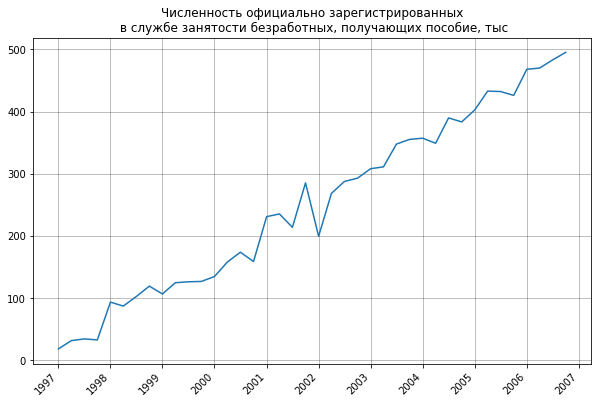

In [10]:
plt.figure(figsize=(10, 6))

plt.plot(df[label]);

plt.xticks(rotation=45, ha="right");
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5);
plt.title(label=title);

## Missing Values

Способы заполения нулевых значений для временных рядов.

In [11]:
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

In [12]:
#создаем столбец с пропущенными значениями
df[f'{label}_na'] = df[label].apply(lambda x: None if round(x) % 4 == 0 else x)
#из столбца, созданного выше, создаем новый датафрейм, состоящий только их этого столбца
df_with_nans = df[[f'{label}_na']].rename(columns={f'{label}_na':label})

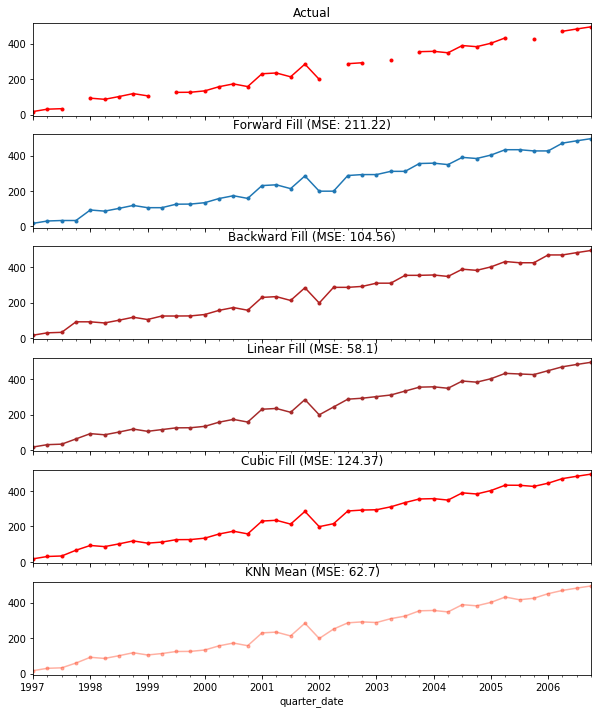

In [13]:
df_orig = df[[label]]

fig, axes = plt.subplots(6, 1, sharex=True, figsize=(10, 12));
plt.rcParams.update({'xtick.bottom' : False});

## 1. Actual -------------------------------
df_with_nans[label].plot(title='Actual', ax=axes[0], \
                     label='Actual', color='red', style=".-");

## 2. Forward Fill --------------------------
df_ffill = df_with_nans.ffill()
error = np.round(mean_squared_error(df_orig[label], df_ffill[label]), 2);
df_ffill[label].plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], \
                     label='Forward Fill', style=".-");

## 3. Backward Fill -------------------------
df_bfill = df_with_nans.bfill()
error = np.round(mean_squared_error(df_orig[label], 
                                    df_bfill[label]), 2);
df_bfill[label].plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], \
                     label='Back Fill', color='firebrick', style=".-");

## 4. Linear Interpolation ------------------
df_with_nans['rownum'] = np.arange(df_with_nans.shape[0])
df_nona = df_with_nans.dropna(subset = [label])
f = interp1d(df_nona['rownum'], df_nona[label])

df_with_nans['linear_fill'] = f(df_with_nans['rownum'])
error = np.round(mean_squared_error(df_orig[label], df_with_nans['linear_fill']), 2);
df_with_nans['linear_fill'].plot(title="Linear Fill (MSE: " + str(error) +")", ax=axes[3], \
                                 label='Linear Fill', color='brown', style=".-");

## 5. Cubic Interpolation --------------------
f2 = interp1d(df_nona['rownum'], df_nona[label], kind='cubic')
df_with_nans['cubic_fill'] = f2(df_with_nans['rownum'])
error = np.round(mean_squared_error(df_orig[label], df_with_nans['cubic_fill']), 2);\
df_with_nans['cubic_fill'].plot(title="Cubic Fill (MSE: " + str(error) +")", ax=axes[4], 
                                label='Cubic Fill', color='red', style=".-");

# # Interpolation References:
# # https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html
# # https://docs.scipy.org/doc/scipy/reference/interpolate.html

## 6. Mean of 'n' Nearest Past Neighbors ------
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out

df_with_nans['knn_mean'] = knn_mean(df_with_nans[label].values, 8)
error = np.round(mean_squared_error(df_orig[label], df_with_nans['knn_mean']), 2)
df_with_nans['knn_mean'].plot(title="KNN Mean (MSE: " + str(error) +")", ax=axes[5], 
                              label='KNN Mean', color='tomato', alpha=0.5, style=".-");


## Тест на стационарность ряда

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
print(" > Is the data stationary ?")
dftest = adfuller(df[label], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {}stationary with {}% confidence"\
          .format(k, v, "not " if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = 0.095
P-value = 0.966
Critical values :
	1%: -3.6209175221605827 - The data is not stationary with 99% confidence
	5%: -2.9435394610388332 - The data is not stationary with 95% confidence
	10%: -2.6104002410518627 - The data is not stationary with 90% confidence


Т.к. ряд нестационарный, необходимо провести преобразования.

## Удаление тренда (detrend)

### 1. Differencing

In [16]:
#столбец с разницей текущего и следующего значений
df['detrended_diff'] = df[label] - df[label].shift(1)

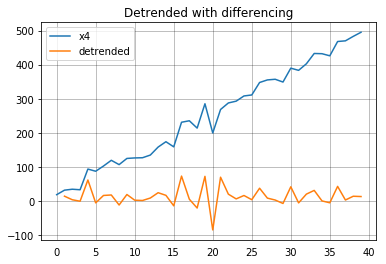

In [17]:
plt.plot(df[label].values, label=label);
plt.plot(df['detrended_diff'].values, label='detrended');
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5);
plt.legend();
plt.title('Detrended with differencing');

### 2. Scipy

In [18]:
from scipy import signal

In [19]:
detrended_with_signal = signal.detrend(df[label].values)
df['detrended_scipy'] = detrended_with_signal

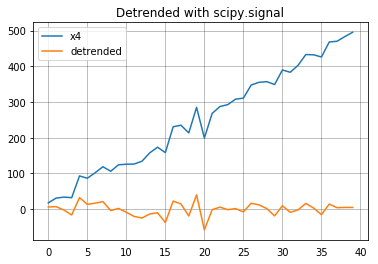

In [20]:
plt.plot(df[label].values, label=label);
plt.plot(detrended_with_signal, label='detrended');

plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5);
plt.legend();
plt.title('Detrended with scipy.signal');

### 3. Using time series decomposition

In [21]:
import statsmodels.api as sm

In [22]:
freq=4

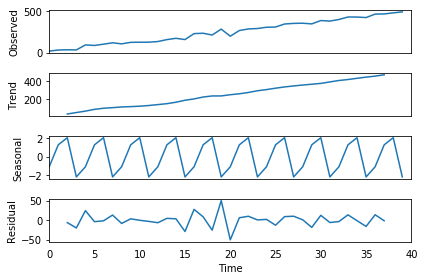

In [23]:
decomposition = sm.tsa.seasonal_decompose(df[label].values, freq=freq, model = 'additive')
resplot = decomposition.plot()

In [24]:
trend = decomposition.trend
resid = decomposition.resid
detrended_with_decomp = df[label].values - trend
df['detrended_sm'] = detrended_with_decomp
df['resid_sm'] = resid

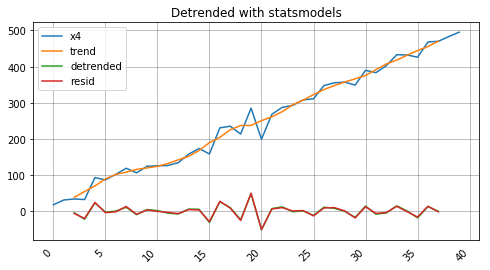

In [25]:
plt.figure(figsize=(8, 4))
plt.plot(df[label].values, label=label);
plt.plot(trend, label='trend');
plt.plot(detrended_with_decomp, label='detrended');
plt.plot(resid, label='resid');
plt.xticks(rotation=45, ha="right");
plt.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.5);
plt.legend();
plt.title('Detrended with statsmodels');

In [26]:
df.head()

,x4,x4_na,detrended_diff,detrended_scipy,detrended_sm,resid_sm
quarter_date,,,,,,
1997-01-01,17.69,17.69,NaN,6.103122,NaN,NaN
1997-04-01,30.95,30.95,13.26,7.082090,NaN,NaN
1997-07-01,33.72,33.72,2.77,-2.428942,-4.32625,-6.387639
1997-10-01,32.16,NaN,-1.56,-16.269974,-22.25500,-20.029861
1998-01-01,93.02,93.02,60.86,32.308994,23.12500,24.241111


## Повторная проверка на стационарность

Выше получили несколько вариантов удаления тренда:
1. detrended_diff
2. detrended_scipy
3. detrended_sm
4. resid_sm

В дальнейшем для построения модели можно взять любой.
Я беру resid_sm.

In [27]:
col = 'resid_sm'

print(" > Is the data stationary ?")
dftest = adfuller(df[col].dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {}stationary with {}% confidence"
          .format(k, v, "not " if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -10.161
P-value = 0.000
Critical values :
	1%: -3.639224104416853 - The data is stationary with 99% confidence
	5%: -2.9512301791166293 - The data is stationary with 95% confidence
	10%: -2.614446989619377 - The data is stationary with 90% confidence


Теперь ряд стационарный и с ним можно работать дальше. 
Но для данных с явно выраженной сезонностью ниже приведен пример избавления от нее. 

## Train

In [28]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [29]:
split_date = pd.Timestamp('2005-01-01')

In [30]:
new_df = df[[col]].dropna()   
split_index = len(new_df.loc[:split_date,:])-1 #-1, т.к pandas при срезах включает концы

In [31]:
print(col)
print(f'split_date: {split_date}')
print(f'length of dataset: {new_df.shape[0]}')
print(f'train_size: {split_index}')
print(f'train_size: {new_df.shape[0] - split_index}') 
print()

resid_sm
split_date: 2005-01-01 00:00:00
length of dataset: 36
train_size: 30
train_size: 6



In [32]:
train, test = new_df.iloc[:split_index,], new_df.iloc[split_index:,]
scaler, train_scaled, test_scaled = scale(train.values, test.values)

In [33]:
#готовим входную матрицу
train_sc_df = pd.DataFrame(train_scaled, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_scaled, columns=['Y'], index=test.index)

#задаем размеры окон
W0 = 2
W1 = 1 #если задать это окно больше 1, то совершенно не очевидно, как визуализировать, поэтому лучше не надо

X_to_drop = []
train_sc_df['X_0'] = train_sc_df['Y']
test_sc_df['X_0'] = test_sc_df['Y']
for s in range(1,W0+W1):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)
    X_to_drop.append('X_{}'.format(s))


#делаем реверс колонок, чтобы данные в историческом порядке шли
train_sc_df = train_sc_df.dropna().drop('Y', axis=1).iloc[:, ::-1] 
test_sc_df = test_sc_df.dropna().drop('Y', axis=1).iloc[:, ::-1]

X_train = train_sc_df.iloc[:, :W0]
y_train = train_sc_df.iloc[:, W0:]
X_test  = test_sc_df.iloc[:, :W0]
y_test  = test_sc_df.iloc[:, W0:]

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()
X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

Получили X_train, y_train, X_test, y_test, которые надо будет совсем немного преобразовать для подачи на вход каждой из моделей.

## MLP

In [34]:
X_train_mlp = X_train
y_train_mlp = y_train.ravel()

X_test_mlp  = X_test
y_test_mlp  = y_test.ravel()

In [35]:
mlp_model = Sequential()

mlp_model.add(Dense(12, input_dim=W0, activation='relu'))
mlp_model.add(Dense(W1))
mlp_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = mlp_model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=1, verbose=1, callbacks=[early_stop], 
                       shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0883
Epoch 2/100
28/28 [==============================] - 0s 677us/step - loss: 0.0828
Epoch 3/100
28/28 [==============================] - 0s 642us/step - loss: 0.0787
Epoch 4/100
28/28 [==============================] - 0s 712us/step - loss: 0.0751
Epoch 5/100
28/28 [==============================] - 0s 678us/step - loss: 0.0720
Epoch 6/100
28/28 [==============================] - 0s 641us/step - loss: 0.0694
Epoch 7/100
28/28 [==============================] - 0s 677us/step - loss: 0.0673
Epoch 8/100
28/28 [==============================] - 0s 677us/step - loss: 0.0655
Epoch 9/100
28/28 [==============================] - 0s 605us/step - loss: 0.0641
Epoch 10/100
28/28 [==============================] - 0s 604us/step - loss: 0.0628
Epoch 11/100
28/28 [==============================] - 0s 604u

28/28 [==============================] - 0s 678us/step - loss: 0.0427
Epoch 93/100
28/28 [==============================] - 0s 677us/step - loss: 0.0426
Epoch 94/100
28/28 [==============================] - ETA: 0s - loss: 1.0162e-0 - 0s 606us/step - loss: 0.0426
Epoch 95/100
28/28 [==============================] - 0s 641us/step - loss: 0.0424
Epoch 96/100
28/28 [==============================] - 0s 642us/step - loss: 0.0424
Epoch 97/100
28/28 [==============================] - 0s 606us/step - loss: 0.0424
Epoch 98/100
28/28 [==============================] - 0s 641us/step - loss: 0.0422
Epoch 99/100
28/28 [==============================] - 0s 605us/step - loss: 0.0422
Epoch 100/100
28/28 [==============================] - 0s 606us/step - loss: 0.0422


## MLP Predict

In [36]:
mlp_y_pred_train = mlp_model.predict(X_train_mlp)
mlp_y_pred_test  = mlp_model.predict(X_test_mlp)

In [37]:
# invert predictions
mlp_trainPredict = scaler.inverse_transform(mlp_y_pred_train)
mlp_trainY = scaler.inverse_transform([y_train_mlp])

mlp_testPredict = scaler.inverse_transform(mlp_y_pred_test)
mlp_testY = scaler.inverse_transform([y_test_mlp])

In [38]:
# calculate root mean squared error
mlp_trainScore = math.sqrt(mean_squared_error(mlp_trainY[0], mlp_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (mlp_trainScore))
mlp_testScore = math.sqrt(mean_squared_error(mlp_testY[0], mlp_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (mlp_testScore))

Train Score: 10.23 RMSE
Test Score: 8.00 RMSE


## LSTM

In [39]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_lstm = y_train

X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_lstm = y_test

In [40]:
# create and fit the LSTM network
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(W0, 1)))
lstm_model.add(Dense(W1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=1, verbose=2);

Epoch 1/100
 - 1s - loss: 0.1212
Epoch 2/100
 - 0s - loss: 0.1182
Epoch 3/100
 - 0s - loss: 0.1156
Epoch 4/100
 - 0s - loss: 0.1129
Epoch 5/100
 - 0s - loss: 0.1116
Epoch 6/100
 - 0s - loss: 0.1083
Epoch 7/100
 - 0s - loss: 0.1060
Epoch 8/100
 - 0s - loss: 0.1036
Epoch 9/100
 - 0s - loss: 0.1011
Epoch 10/100
 - 0s - loss: 0.0989
Epoch 11/100
 - 0s - loss: 0.0960
Epoch 12/100
 - 0s - loss: 0.0943
Epoch 13/100
 - 0s - loss: 0.0914
Epoch 14/100
 - 0s - loss: 0.0903
Epoch 15/100
 - 0s - loss: 0.0860
Epoch 16/100
 - 0s - loss: 0.0831
Epoch 17/100
 - 0s - loss: 0.0810
Epoch 18/100
 - 0s - loss: 0.0790
Epoch 19/100
 - 0s - loss: 0.0760
Epoch 20/100
 - 0s - loss: 0.0742
Epoch 21/100
 - 0s - loss: 0.0720
Epoch 22/100
 - 0s - loss: 0.0699
Epoch 23/100
 - 0s - loss: 0.0681
Epoch 24/100
 - 0s - loss: 0.0670
Epoch 25/100
 - 0s - loss: 0.0652
Epoch 26/100
 - 0s - loss: 0.0638
Epoch 27/100
 - 0s - loss: 0.0620
Epoch 28/100
 - 0s - loss: 0.0607
Epoch 29/100
 - 0s - loss: 0.0599
Epoch 30/100
 - 0s - lo

## LSTM Predict

In [41]:
# make predictions
lstm_y_pred_train = lstm_model.predict(X_train_lstm)
lstm_y_pred_test  = lstm_model.predict(X_test_lstm)

In [42]:
# invert predictions
lstm_trainPredict = scaler.inverse_transform(lstm_y_pred_train)
lstm_trainY = scaler.inverse_transform([y_train_lstm.ravel()])

lstm_testPredict = scaler.inverse_transform(lstm_y_pred_test)
lstm_testY = scaler.inverse_transform([y_test_lstm.ravel()])

In [43]:
# calculate root mean squared error
lstm_trainScore = math.sqrt(mean_squared_error(lstm_trainY[0], lstm_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (lstm_trainScore))
lstm_testScore = math.sqrt(mean_squared_error(lstm_testY[0], lstm_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (lstm_testScore))

Train Score: 11.37 RMSE
Test Score: 7.71 RMSE


## Compare models

**Замечание**

Если W1 задавали больше 1, то эта визуализация не сработает по понятным причинам. <br>
Надо подумать, что делать с предсказанием на 2 и более значений. Мб усреднять.


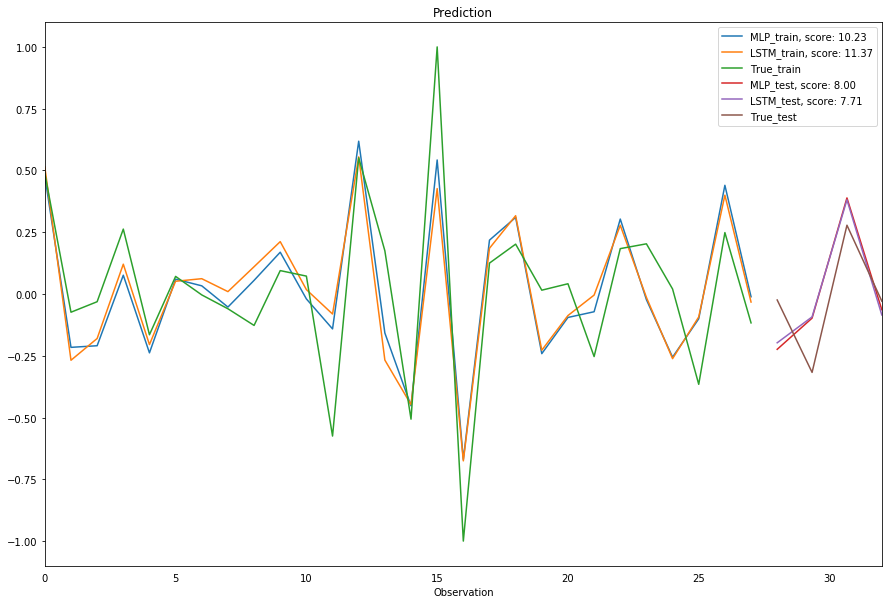

In [44]:
tr_len  = len(lstm_y_pred_train)
tst_len = len(lstm_y_pred_test)

plt.figure(figsize=(15, 10))

plt.plot(mlp_y_pred_train, label=f'MLP_train, score: {mlp_trainScore:.2f}')
plt.plot(lstm_y_pred_train, label=f'LSTM_train, score: {lstm_trainScore:.2f}')
plt.plot(y_train, label='True_train')
x = np.linspace(tr_len,tr_len+tst_len,tst_len)
plt.plot(x, mlp_y_pred_test, label=f'MLP_test, score: {mlp_testScore:.2f}')
plt.plot(x, lstm_y_pred_test, label=f'LSTM_test, score: {lstm_testScore:.2f}')
plt.plot(x, y_test, label='True_test')

plt.title("Prediction")
plt.xlabel('Observation')
plt.xlim((0,tr_len+tst_len))
plt.legend()
plt.show();

# На этом обязательная часть закончилась.

## Далее - по желанию (наверное).

## Тут обучение нескольких моделей с целью выбрать лучшую (перебор параметров, все дела).

Но перебор параметров - рандомный, а не оптимальный. Ибо как оптимальный написать - я хз (точнее дайте мне время, и будет вам оптимальный. Но времени нет - значит и оптимального перебора тоже нет, так-то). 

А дальше для каждой из двух архитектур (MLP и LSTM) пишем цикл

In [45]:
#задаем словарь с различными значениями параметров сети (параметры можно любые указывать, я просто пример привожу)

params = {'num_of_hidden_layers' : [1,2,3],      #число скрытых слоев (если вдруг хотим несколько)
          'num_of_hidden_neurons': [5,10,15,20], #число скрытых нейронов на в слое (если хоти несколько слоев, то этот параметр будет для каждого слоя выбираться заново)
          'epochs': [50, 100, 200, 300],        #число эпох
          'activation': ['relu', 'linear']       #функция активации (про linear не уверена, но вроде есть такая)
        }

In [46]:
directory_1 = './models'
directory_2 = directory_1 + '/mlp'
directory_3 = directory_1 + '/lstm'

directories = [directory_1, directory_2, directory_3]
#cоздаем папки, в которе будут складываться обученные модели (папки создадутся в той же директории, где лежит ноутбук)
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

## 5 MLP models

In [47]:
#выше уже задавали, но на всякий случай повторим

X_train_mlp = X_train
y_train_mlp = y_train.ravel()

X_test_mlp  = X_test
y_test_mlp  = y_test.ravel()

In [48]:
from keras.models import load_model
from keras.models import save_model

In [49]:
#например, хотим 5 сетей
n = 5

#в этот словарь можно складывать полученные результаты работы всех пяти моделей(predict и параметры моделей)
mlp_dict = {} 

for i in range(n):
    
    #инициализировали модель
    model = Sequential()
    #словарь, в который будем параметры складывать
    tmp_params = {}
    
    #выбираем рандомные параметры для первого слоя
    num_of_hid_neur_0 = random.choice(params['num_of_hidden_neurons']) 
    activation_0 = random.choice(params['activation']) 
    #записываем параметры в словарь
    tmp_params['num_of_hid_neur_0'] = num_of_hid_neur_0
    tmp_params['activation_0'] = activation_0
    #добавляем первый слой с выбранными выше параметрами
    model.add(Dense(num_of_hid_neur_0, input_dim=W0, activation=activation_0))
    
    #выбираем число скрытых слоев
    num_of_hidden_layers = random.choice(params['num_of_hidden_layers']) 
    #добавляем число слоев в словарь
    tmp_params['num_of_hidden_layers'] = num_of_hidden_layers

    for j in range(0, num_of_hidden_layers):
        
        #выбираем рандомные параметры для этого слоя
        num_of_hid_neur_j = random.choice(params['num_of_hidden_neurons'])
        activation_j = random.choice(params['activation']) 
        #добавляем параметры слоя в словарь
        tmp_params[f'num_of_hid_neur_{j+1}'] = num_of_hid_neur_j
        tmp_params[f'activation_{j+1}'] = activation_j
        #добавляем сам слой
        model.add(Dense(num_of_hid_neur_j, activation=activation_j)) #тут j - просто часть имени, а не параметр 
        
    
    #задаем выходной слой
    activation_out = random.choice(params['activation']) 
    tmp_params['activation_out'] = activation_out
    model.add(Dense(W1, activation=activation_out))

    #compile
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    
    epochs = random.choice(params['epochs']) 
    tmp_params['epochs'] = epochs
    
    print(f'start training model {i}')
    print(f'params: {tmp_params}')
    history = model.fit(X_train_mlp, y_train_mlp, epochs=epochs, batch_size=1, 
                            verbose=1, callbacks=[early_stop], shuffle=False)
    
    
    #дальше надо сделать predict  
    mlp_y_pred_train = model.predict(X_train_mlp)
    mlp_y_pred_test  = model.predict(X_test_mlp)
    
    
    # invert predictions
    mlp_trainPredict = scaler.inverse_transform(mlp_y_pred_train)
    mlp_trainY = scaler.inverse_transform([y_train_mlp])
    mlp_testPredict = scaler.inverse_transform(mlp_y_pred_test)
    mlp_testY = scaler.inverse_transform([y_test_mlp])
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(mlp_trainY[0], mlp_trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(mlp_testY[0], mlp_testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    print()
    
    #дальше все собираем в словарь, чтобы потом из него можно было достать то, что нам надо (для лучше модели)
    mlp_dict[f'model_{i}'] = {'params': tmp_params, 
                              'prediction': {'y_pred_train': mlp_y_pred_train.ravel(), 
                                             'y_pred_test': mlp_y_pred_test.ravel()},
                              'train_score': trainScore,
                              'test_score': testScore
                             }
    
    #а теперь сохраняем полученную модель 
    model.save(f'{directory_2}/model_{i}', include_optimizer=True)

start training model 0
params: {'num_of_hid_neur_0': 15, 'activation_0': 'relu', 'num_of_hidden_layers': 3, 'num_of_hid_neur_1': 20, 'activation_1': 'relu', 'num_of_hid_neur_2': 10, 'activation_2': 'relu', 'num_of_hid_neur_3': 15, 'activation_3': 'relu', 'activation_out': 'linear', 'epochs': 300}
Epoch 1/300
28/28 [==============================] - 0s 12ms/step - loss: 0.1290
Epoch 2/300
28/28 [==============================] - 0s 926us/step - loss: 0.1145
Epoch 3/300
28/28 [==============================] - 0s 998us/step - loss: 0.1026
Epoch 4/300
28/28 [==============================] - 0s 891us/step - loss: 0.0917
Epoch 5/300
28/28 [==============================] - 0s 890us/step - loss: 0.0810
Epoch 6/300
28/28 [==============================] - 0s 962us/step - loss: 0.0708
Epoch 7/300
28/28 [==============================] - 0s 892us/step - loss: 0.0627
Epoch 8/300
28/28 [==============================] - 0s 854us/step - loss: 0.0576
Epoch 9/300
28/28 [============================

28/28 [==============================] - 0s 641us/step - loss: 0.0876
Epoch 34/100
28/28 [==============================] - 0s 641us/step - loss: 0.0873
Epoch 35/100
28/28 [==============================] - 0s 641us/step - loss: 0.0872
Epoch 36/100
28/28 [==============================] - 0s 606us/step - loss: 0.0870
Epoch 37/100
28/28 [==============================] - 0s 641us/step - loss: 0.0867
Epoch 38/100
28/28 [==============================] - 0s 605us/step - loss: 0.0866
Epoch 39/100
28/28 [==============================] - 0s 641us/step - loss: 0.0864
Epoch 40/100
28/28 [==============================] - 0s 641us/step - loss: 0.0863
Epoch 41/100
28/28 [==============================] - 0s 641us/step - loss: 0.0860
Epoch 42/100
28/28 [==============================] - 0s 605us/step - loss: 0.0859
Epoch 43/100
28/28 [==============================] - 0s 641us/step - loss: 0.0856
Epoch 44/100
28/28 [==============================] - 0s 748us/step - loss: 0.0855
Epoch 45/100
28/2

28/28 [==============================] - 0s 677us/step - loss: 0.0979
Epoch 20/100
28/28 [==============================] - 0s 714us/step - loss: 0.0969
Epoch 21/100
28/28 [==============================] - 0s 713us/step - loss: 0.0956
Epoch 22/100
28/28 [==============================] - 0s 855us/step - loss: 0.0945
Epoch 23/100
28/28 [==============================] - 0s 712us/step - loss: 0.0933
Epoch 24/100
28/28 [==============================] - 0s 819us/step - loss: 0.0922
Epoch 25/100
28/28 [==============================] - 0s 748us/step - loss: 0.0913
Epoch 26/100
28/28 [==============================] - 0s 819us/step - loss: 0.0905
Epoch 27/100
28/28 [==============================] - 0s 819us/step - loss: 0.0896
Epoch 28/100
28/28 [==============================] - 0s 997us/step - loss: 0.0890
Epoch 29/100
28/28 [==============================] - 0s 855us/step - loss: 0.0883
Epoch 30/100
28/28 [==============================] - 0s 925us/step - loss: 0.0877
Epoch 31/100
28/2

In [50]:
#посмотрим на параметры обученных моделей
mlp_dict

{'model_0': {'params': {'num_of_hid_neur_0': 15,
   'activation_0': 'relu',
   'num_of_hidden_layers': 3,
   'num_of_hid_neur_1': 20,
   'activation_1': 'relu',
   'num_of_hid_neur_2': 10,
   'activation_2': 'relu',
   'num_of_hid_neur_3': 15,
   'activation_3': 'relu',
   'activation_out': 'linear',
   'epochs': 300},
  'prediction': {'y_pred_train': array([ 0.4425652 , -0.03371134, -0.02027996,  0.13863367, -0.14739446,
           0.12955582,  0.1258439 , -0.16999143, -0.05057864,  0.12138052,
           0.08371506, -0.3308577 ,  0.7264951 ,  0.08864652, -0.43893322,
           0.73270404, -0.90474236,  0.2304106 ,  0.25727051, -0.0310904 ,
          -0.1951535 , -0.14457516,  0.2359996 ,  0.09159576, -0.03624041,
          -0.20252474,  0.37828875,  0.09893455], dtype=float32),
   'y_pred_test': array([-0.18836343, -0.11070225,  0.3102804 ,  0.06873443], dtype=float32)},
  'train_score': 6.249957874314105,
  'test_score': 7.109538905001942},
 'model_1': {'params': {'num_of_hid_neur_

In [51]:
#вытянем из словаря mlp_dict индексы моделей и их ошибки
mlp_scores = []
for i in mlp_dict:
    train_score = mlp_dict[i]['train_score']
    test_score = mlp_dict[i]['test_score']
    
    mlp_scores.append((i, train_score, test_score))
    print(f'{i} train score: {train_score}')
    print(f'{i} test score: {test_score}')
    print()

model_0 train score: 6.249957874314105
model_0 test score: 7.109538905001942

model_1 train score: 14.360901233538373
model_1 test score: 8.642236537140732

model_2 train score: 18.27233806327462
model_2 test score: 10.63991596531953

model_3 train score: 14.35613033292565
model_3 test score: 8.697309220394548

model_4 train score: 14.280045255899607
model_4 test score: 8.641875059310129



In [52]:
#выберем лучшую модель
mlp_scores.sort(key=lambda tup: tup[2], reverse=True) 
best_mlp_score = mlp_scores[-1]
print(f'MLP best_score: {best_mlp_score}') #лучшая модель та, у которой ошибка меньше

MLP best_score: ('model_0', 6.249957874314105, 7.109538905001942)


In [53]:
#по этим штукам потом будем графики строить
best_mlp_y_pred_train = mlp_dict[best_mlp_score[0]]['prediction']['y_pred_train']
best_mlp_trainScore = best_mlp_score[1]
best_mlp_y_pred_test = mlp_dict[best_mlp_score[0]]['prediction']['y_pred_test']
best_mlp_testScore = best_mlp_score[2]

# 5 LSTM models

Теперь все аналогично, только для LSTM

In [54]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train_lstm = y_train

X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test_lstm = y_test

In [55]:
#например, хотим 5 сетей
n = 5

#в этот словарь можно складывать полученные результаты работы всех пяти моделей(predict и параметры моделей)
lstm_dict = {} 

for i in range(n):
    
    #инициализировали модель
    model = Sequential()
    #словарь, в который будем параметры складывать
    tmp_params = {}
    
    #выбираем рандомные параметры для первого слоя
    num_of_hid_neur_0 = random.choice(params['num_of_hidden_neurons']) 
    activation_0 = random.choice(params['activation']) 
    #записываем параметры в словарь
    tmp_params['num_of_hid_neur_0'] = num_of_hid_neur_0
    tmp_params['activation_0'] = activation_0
    #добавляем первый слой с выбранными выше параметрами
    model.add(LSTM(num_of_hid_neur_0, input_shape=(W0, 1), activation=activation_0))
    
    #выбираем число скрытых слоев
    num_of_hidden_layers = random.choice(params['num_of_hidden_layers']) 
    #добавляем число слоев в словарь
    tmp_params['num_of_hidden_layers'] = num_of_hidden_layers

    for j in range(0, num_of_hidden_layers):
        
        #выбираем рандомные параметры для этого слоя
        num_of_hid_neur_j = random.choice(params['num_of_hidden_neurons'])
        activation_j = random.choice(params['activation']) 
        #добавляем параметры слоя в словарь
        tmp_params[f'num_of_hid_neur_{j+1}'] = num_of_hid_neur_j
        tmp_params[f'activation_{j+1}'] = activation_j
        #добавляем сам слой
        model.add(Dense(num_of_hid_neur_j, activation=activation_j)) #тут j - просто часть имени, а не параметр 
        
    
    #задаем выходной слой
    activation_out = random.choice(params['activation']) 
    tmp_params['activation_out'] = activation_out
    model.add(Dense(W1, activation=activation_out))

    #compile
    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    
    epochs = random.choice(params['epochs']) 
    tmp_params['epochs'] = epochs
    
    print(f'start training model {i}')
    print(f'params: {tmp_params}')
    history = model.fit(X_train_lstm, y_train_lstm, epochs=epochs, batch_size=1, 
                            verbose=1, callbacks=[early_stop], shuffle=False)
    
    
    #дальше надо сделать predict  
    lstm_y_pred_train = model.predict(X_train_lstm)
    lstm_y_pred_test  = model.predict(X_test_lstm)
    
    
    # invert predictions
    lstm_trainPredict = scaler.inverse_transform(lstm_y_pred_train)
    lstm_trainY = scaler.inverse_transform([y_train_lstm.ravel()])
    lstm_testPredict = scaler.inverse_transform(lstm_y_pred_test)
    lstm_testY = scaler.inverse_transform([y_test_lstm.ravel()])
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(lstm_trainY[0], lstm_trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(lstm_testY[0], lstm_testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    print()
    
    #дальше все собираем в словарь, чтобы потом из него можно было достать то, что нам надо (для лучше модели)
    lstm_dict[f'model_{i}'] = {'params': tmp_params, 
                              'prediction': {'y_pred_train': lstm_y_pred_train.ravel(), 
                                             'y_pred_test': lstm_y_pred_test.ravel()},
                              'train_score': trainScore,
                              'test_score': testScore
                             }
    
    #а теперь сохраняем полученную модель (СОЗДАЙТЕ ПАПКУ "models" ТАМ, ГДЕ ЛЕЖИТ НОУТБУК)
    model.save(f'{directory_3}/model_{i}', include_optimizer=True)

start training model 0
params: {'num_of_hid_neur_0': 20, 'activation_0': 'relu', 'num_of_hidden_layers': 2, 'num_of_hid_neur_1': 20, 'activation_1': 'relu', 'num_of_hid_neur_2': 20, 'activation_2': 'linear', 'activation_out': 'linear', 'epochs': 200}
Epoch 1/200
28/28 [==============================] - 1s 34ms/step - loss: 0.1251
Epoch 2/200
28/28 [==============================] - 0s 2ms/step - loss: 0.1175
Epoch 3/200
28/28 [==============================] - 0s 2ms/step - loss: 0.1107
Epoch 4/200
28/28 [==============================] - 0s 2ms/step - loss: 0.1029
Epoch 5/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0938
Epoch 6/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0847
Epoch 7/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0762
Epoch 8/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0691
Epoch 9/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0640
Epoch 10/200
28/28 [========

28/28 [==============================] - 0s 1ms/step - loss: 0.0995
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0921
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0853
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0790
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0741
Epoch 11/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0701
Epoch 12/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0676
Epoch 13/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0655
Epoch 14/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0646
Epoch 15/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0634
Epoch 16/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0630
Epoch 17/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0622
Epoch 18/200
28/28 [========================

28/28 [==============================] - 0s 1ms/step - loss: 0.1035
Epoch 4/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0933
Epoch 5/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0831
Epoch 6/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0753
Epoch 7/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0683
Epoch 8/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0651
Epoch 9/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0618
Epoch 10/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 11/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0585
Epoch 12/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 13/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0562
Epoch 14/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0546
Epoch 15/200
28/28 [===========================

28/28 [==============================] - 0s 1ms/step - loss: 0.0684
Epoch 20/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0659
Epoch 21/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0643
Epoch 22/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0628
Epoch 23/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0613
Epoch 24/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0610
Epoch 25/200
28/28 [==============================] - 0s 2ms/step - loss: 0.0593
Epoch 26/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0583
Epoch 27/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0567
Epoch 28/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0564
Epoch 29/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0547
Epoch 30/200
28/28 [==============================] - 0s 1ms/step - loss: 0.0533
Epoch 31/200
28/28 [=====================

In [56]:
#посмотрим на параметры обученных моделей
lstm_dict

{'model_0': {'params': {'num_of_hid_neur_0': 20,
   'activation_0': 'relu',
   'num_of_hidden_layers': 2,
   'num_of_hid_neur_1': 20,
   'activation_1': 'relu',
   'num_of_hid_neur_2': 20,
   'activation_2': 'linear',
   'activation_out': 'linear',
   'epochs': 200},
  'prediction': {'y_pred_train': array([ 0.51646394, -0.00901381, -0.06415182, -0.01165766, -0.1686357 ,
           0.13022858, -0.01964537, -0.09902757, -0.0200199 ,  0.1011933 ,
          -0.05904151, -0.15949057,  0.6744721 ,  0.06449176, -0.5072829 ,
           0.6458395 , -0.9883422 ,  0.09663736,  0.21007429, -0.18883914,
          -0.11604118, -0.14747536,  0.24404106,  0.0183591 , -0.19384716,
          -0.12135821,  0.4137674 ,  0.0759807 ], dtype=float32),
   'y_pred_test': array([-0.15445824, -0.06142585,  0.35657582,  0.0260672 ], dtype=float32)},
  'train_score': 8.092329158286677,
  'test_score': 7.597560551204401},
 'model_1': {'params': {'num_of_hid_neur_0': 15,
   'activation_0': 'linear',
   'num_of_hidde

In [57]:
#вытянем из словаря mlp_dict индексы моделей и их ошибки
lstm_scores = []
for i in lstm_dict:
    train_score = lstm_dict[i]['train_score']
    test_score = lstm_dict[i]['test_score']
    
    lstm_scores.append((i, train_score, test_score))
    print(f'{i} train score: {train_score}')
    print(f'{i} test score: {test_score}')
    print()

model_0 train score: 8.092329158286677
model_0 test score: 7.597560551204401

model_1 train score: 8.525437005891702
model_1 test score: 8.401139964267248

model_2 train score: 10.42768194262779
model_2 test score: 7.496028780171899

model_3 train score: 11.155562523814044
model_3 test score: 7.14931646878761

model_4 train score: 9.382828131525411
model_4 test score: 7.479921284979735



In [58]:
#выберем лучшую модель
lstm_scores.sort(key=lambda tup: tup[2], reverse=True)  
best_lstm_score = lstm_scores[-1]
print(f'LSTM best_score: {best_lstm_score}') #лучшая модель та, у которой на тестовой выборке ошибка меньше

LSTM best_score: ('model_3', 11.155562523814044, 7.14931646878761)


In [59]:
best_lstm_y_pred_train = lstm_dict[best_lstm_score[0]]['prediction']['y_pred_train']
best_lstm_trainScore = best_lstm_score[1]
best_lstm_y_pred_test = lstm_dict[best_lstm_score[0]]['prediction']['y_pred_test']
best_lstm_testScore = best_lstm_score[2]

# Снова строим график и глядим на него пристально (радуемся, что такие чудесные модели обучили)

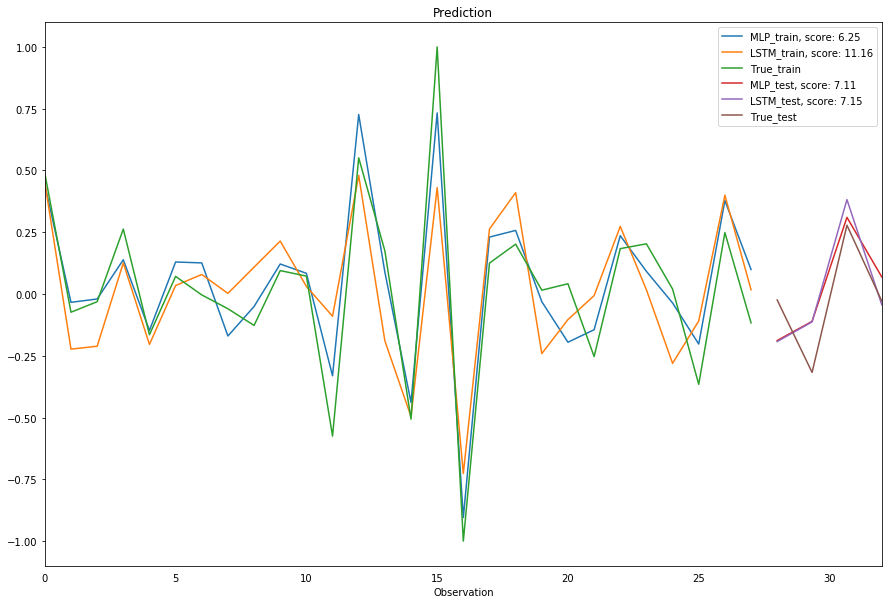

In [60]:
tr_len  = len(lstm_y_pred_train)
tst_len = len(lstm_y_pred_test)

plt.figure(figsize=(15, 10))

plt.plot(best_mlp_y_pred_train, label=f'MLP_train, score: {best_mlp_trainScore:.2f}')
plt.plot(best_lstm_y_pred_train, label=f'LSTM_train, score: {best_lstm_trainScore:.2f}')
plt.plot(y_train, label='True_train')
x = np.linspace(tr_len,tr_len+tst_len,tst_len)
plt.plot(x, best_mlp_y_pred_test, label=f'MLP_test, score: {best_mlp_testScore:.2f}')
plt.plot(x, best_lstm_y_pred_test, label=f'LSTM_test, score: {best_lstm_testScore:.2f}')
plt.plot(x, y_test, label='True_test')

plt.title("Prediction")
plt.xlabel('Observation')
plt.xlim((0,tr_len+tst_len))
plt.legend()
plt.show();

Ну и последний шаг: сравнить с тем, что мы получили без перебора параметров

In [61]:
print('Ошибки моделей ДО перебора параметров:')
print(f'MLP train score: {mlp_trainScore:.2f}')
print(f'MLP test score: {mlp_testScore:.2f}')
print(f'LSTM train score: {lstm_trainScore:.2f}')
print(f'LSTM test score: {lstm_testScore:.2f}')
print()
print('Ошибки моделей ПОСЛЕ перебора параметров:')
print(f'MLP train score: {best_mlp_trainScore:.2f}')
print(f'MLP test score: {best_mlp_testScore:.2f}')
print(f'LSTM train score: {best_lstm_trainScore:.2f}')
print(f'LSTM test score: {best_lstm_testScore:.2f}')

Ошибки моделей ДО перебора параметров:
MLP train score: 10.23
MLP test score: 8.00
LSTM train score: 11.37
LSTM test score: 7.71

Ошибки моделей ПОСЛЕ перебора параметров:
MLP train score: 6.25
MLP test score: 7.11
LSTM train score: 11.16
LSTM test score: 7.15


In [62]:
print('MLP best params')
print(mlp_dict[best_mlp_score[0]]['params'])

MLP best params
{'num_of_hid_neur_0': 15, 'activation_0': 'relu', 'num_of_hidden_layers': 3, 'num_of_hid_neur_1': 20, 'activation_1': 'relu', 'num_of_hid_neur_2': 10, 'activation_2': 'relu', 'num_of_hid_neur_3': 15, 'activation_3': 'relu', 'activation_out': 'linear', 'epochs': 300}


In [63]:
print('LSTM best params')
print(lstm_dict[best_lstm_score[0]]['params'])

LSTM best params
{'num_of_hid_neur_0': 10, 'activation_0': 'linear', 'num_of_hidden_layers': 2, 'num_of_hid_neur_1': 5, 'activation_1': 'relu', 'num_of_hid_neur_2': 20, 'activation_2': 'linear', 'activation_out': 'linear', 'epochs': 100}


Видим, что на тестовой выборке для обеих вариантов (MLP и LSTM) получили результаты лучше. <br>
### Ура! Значит, все не зря!

Ну и самый последний шаг. <br>
Если мы хотим на наших моделях и дальше предсказывать, то можем запросто их считать. <br>
Мы же сообразительные ребята, мы сохранили их в папочку.

In [64]:
from keras.models import load_model

In [65]:
#я хочу считать, допустим, модель MLP версии model_1
path_to_best_model = directory_2 + '/model_1'
path_to_best_model

'./models/mlp/model_1'

In [66]:
model = load_model(path_to_best_model)

In [67]:
#ну вот и все!
#дальше можно модель.предикт и погнали!

In [68]:
# _SOME_NEW_DATA_ - какая-то новая выборка, на которой хотим получить предсказания
# это просто для примера, ЯЧЕЙКУ ЗАПУСКАТЬ НЕ НАДООООО
#model.predict(_SOME_NEW_DATA_)